# Machine learning for anomaly detection and condition monitoring

This notebook is based on the same article at this URL: https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770

For an introduction to anomaly detection and condition monitoring, I recommend first reading my original article on the topic: https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7
This provides the neccesary background information on how machine learning and data driven analytics can be utilized to extract valuable information from sensor data.

The current article focuses mostly on the technical aspects, and includes all the code needed to set up anomaly detection models based on multivariate statistical analysis and autoencoder neural networks.

Each data set consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. Each file consists of 20.480 points with the sampling rate set at 20 kHz. The file name indicates when the data was collected. Each record (row) in the data file is a data point. Larger intervals of time stamps (showed in file names) indicate resumption of the experiment in the next working day.

## Import packages and libraries:

The first step is to import some useful packages and libraries for the analysis:

In [62]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
# from tensorflow import set_random_seed

import tensorflow as tf

from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.models import model_from_json

## Data loading and pre-processing:

An assumption is that gear degradation occur gradually over time, so we use one datapoint every 10 minutes in the following analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20.480 datapoints in each file. We then merge together everything in a single dataframe.

In the following example, I use the data from the 2nd Gear failure test (see readme document for further info on that experiment).

Data is available here (last checked on Nov./16/2020)
https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan

In [8]:
data_dir = '2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    print(filename)
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

2004.02.14.06.22.39
2004.02.15.11.12.39
2004.02.15.21.32.39
2004.02.15.23.12.39
2004.02.16.16.12.39
2004.02.13.20.42.39
2004.02.14.09.52.39
2004.02.16.23.12.39
2004.02.14.10.22.39
2004.02.16.18.22.39
2004.02.17.18.42.39
2004.02.17.13.32.39
2004.02.16.10.32.39
2004.02.16.19.02.39
2004.02.16.07.32.39
2004.02.18.01.32.39
2004.02.16.11.02.39
2004.02.15.18.52.39
2004.02.15.16.12.39
2004.02.15.20.12.39
2004.02.16.07.22.39
2004.02.17.00.32.39
2004.02.17.22.42.39
2004.02.17.15.32.39
2004.02.16.17.32.39
2004.02.15.23.32.39
2004.02.17.17.12.39
2004.02.17.12.12.39
2004.02.18.21.22.39
2004.02.15.22.22.39
2004.02.19.01.02.39
2004.02.18.11.52.39
2004.02.16.10.42.39
2004.02.15.09.12.39
2004.02.14.00.52.39
2004.02.16.16.42.39
2004.02.15.17.52.39
2004.02.19.00.32.39
2004.02.15.07.32.39
2004.02.14.14.42.39
2004.02.17.19.12.39
2004.02.19.02.12.39
2004.02.13.23.12.39
2004.02.17.04.12.39
2004.02.16.01.32.39
2004.02.17.16.12.39
2004.02.17.23.42.39
2004.02.13.11.52.39
2004.02.19.00.02.39
2004.02.13.06.52.39


2004.02.16.02.22.39
2004.02.17.20.12.39
2004.02.13.20.12.39
2004.02.13.21.12.39
2004.02.15.09.22.39
2004.02.13.09.22.39
2004.02.18.04.52.39
2004.02.17.12.42.39
2004.02.16.06.12.39
2004.02.13.05.22.39
2004.02.14.00.12.39
2004.02.17.21.12.39
2004.02.13.06.02.39
2004.02.15.12.42.39
2004.02.12.15.32.39
2004.02.14.06.42.39
2004.02.14.15.02.39
2004.02.13.05.52.39
2004.02.18.09.22.39
2004.02.18.08.42.39
2004.02.15.13.02.39
2004.02.16.12.12.39
2004.02.15.01.12.39
2004.02.16.20.22.39
2004.02.19.02.22.39
2004.02.17.06.02.39
2004.02.18.04.22.39
2004.02.12.12.12.39
2004.02.18.13.32.39
2004.02.16.20.42.39
2004.02.17.17.52.39
2004.02.16.05.12.39
2004.02.12.21.22.39
2004.02.14.04.42.39
2004.02.18.20.12.39
2004.02.13.07.12.39
2004.02.15.18.02.39
2004.02.15.14.32.39
2004.02.12.20.02.39
2004.02.17.20.02.39
2004.02.17.11.52.39
2004.02.16.00.22.39
2004.02.18.02.42.39
2004.02.13.03.42.39
2004.02.15.05.02.39
2004.02.14.08.02.39
2004.02.18.23.42.39
2004.02.12.19.32.39
2004.02.18.19.22.39
2004.02.18.04.32.39


2004.02.18.12.02.39
2004.02.16.00.12.39
2004.02.14.04.12.39
2004.02.15.09.02.39
2004.02.14.13.32.39
2004.02.18.08.12.39
2004.02.16.18.52.39
2004.02.15.14.42.39
2004.02.16.09.32.39
2004.02.18.17.12.39
2004.02.17.06.52.39
2004.02.17.17.02.39
2004.02.14.21.02.39
2004.02.12.18.12.39
2004.02.18.18.42.39
2004.02.13.04.42.39
2004.02.12.17.32.39
2004.02.14.15.22.39
2004.02.15.07.12.39
2004.02.12.13.12.39
2004.02.15.05.32.39
2004.02.13.22.42.39
2004.02.19.05.02.39
2004.02.18.07.22.39
2004.02.15.08.32.39
2004.02.16.20.32.39
2004.02.14.13.52.39
2004.02.16.09.12.39
2004.02.18.07.32.39
2004.02.13.16.52.39
2004.02.16.20.52.39
2004.02.14.07.02.39
2004.02.16.02.02.39
2004.02.14.01.12.39
2004.02.13.17.32.39
2004.02.13.15.12.39
2004.02.15.08.02.39
2004.02.19.01.42.39
2004.02.14.22.42.39
2004.02.17.07.12.39
2004.02.18.03.02.39
2004.02.14.18.22.39
2004.02.17.12.22.39
2004.02.12.20.42.39
2004.02.14.06.32.39
2004.02.16.05.02.39
2004.02.12.19.52.39
2004.02.13.05.32.39
2004.02.14.08.42.39
2004.02.16.14.32.39


In [10]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


## Define train/test data:

Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions), and test on the remaining parts of the dataset leading up to the bearing failure.

<AxesSubplot:>

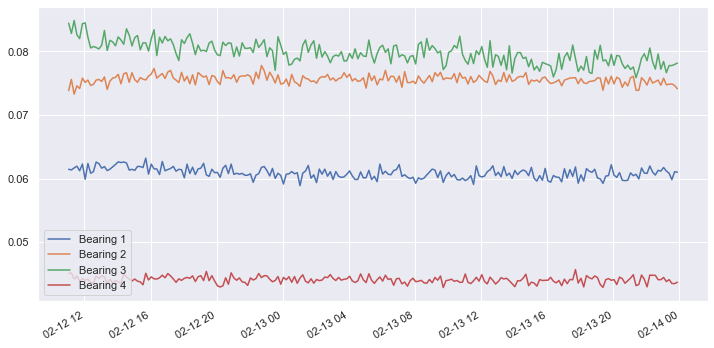

In [12]:
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
dataset_train.plot(figsize = (12,6))

## Normalize data:

I then use preprocessing tools from Scikit-learn to scale the input variables of the model. The “MinMaxScaler” simply re-scales the data to be in the range [0,1].

In [13]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

## PCA type model for anomaly detection:

As dealing with high dimensional sensor data is often challenging, there are several techniques to reduce the number of variables (dimensionality reduction). One of the main techniques is principal component analysis (PCA). For a more detailed introduction, I refer to my original article on the topic.

As an initial attempt, let us compress the sensor readings down to the two main principal components.

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver= 'full')

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

## The Mahalanobis distance metric:

The Mahalanobis distance is widely used in cluster analysis and classification techniques. In order to use the Mahalanobis distance to classify a test point as belonging to one of N classes, one first estimates the covariance matrix of each class, usually based on samples known to belong to each class. In our case, as we are only interested in classifying “normal” vs “anomaly”, we use training data that only contains normal operating conditions to calculate the covariance matrix. Then, given a test sample, we compute the Mahalanobis distance to the “normal” class, and classifies the test point as an “anomaly” if the distance is above a certain threshold.

## Define functions used in the PCA model:

Calculate the covariance matrix:

In [28]:
def cov_matrix(data, verbose=False):
    
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

Calculate the Mahalanobis distance:

In [29]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

Detecting outliers:

In [30]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

Calculate threshold value for classifying datapoint as anomaly:

In [38]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

Check if matrix is positive definite:

In [31]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

## Set up PCA model:

Define train/test set from the two main principal components:

In [32]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

Calculate the covariance matrix and its inverse, based on data in the training set:

In [33]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

We also calculate the mean value for the input variables in the training set, as this is used later to calculate the Mahalanobis distance to datapoints in the test set

In [39]:
mean_distr = data_train.mean(axis=0)

Using the covariance matrix and its inverse, we can calculate the Mahalanobis distance for the training data defining “normal conditions”, and find the threshold value to flag datapoints as an anomaly. One can then calculate the Mahalanobis distance for the datapoints in the test set, and compare that with the anomaly threshold.

In [40]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

## Threshold value for flagging an anomaly:

The square of the Mahalanobis distance to the centroid of the distribution should follow a χ2 distribution if the assumption of normal distributed input variables is fulfilled. This is also the assumption behind the above calculation of the “threshold value” for flagging an anomaly. As this assumption is not necessarily fulfilled in our case, it is beneficial to visualize the distribution of the Mahalanobis distance to set a good threshold value for flagging anomalies. Again, I refer to my previous article, for a more detailed introduction to these technical aspects.

We start by visualizing the square of the Mahalanobis distance, which should then ideally follow a χ2 distribution.

(0.0, 15.0)

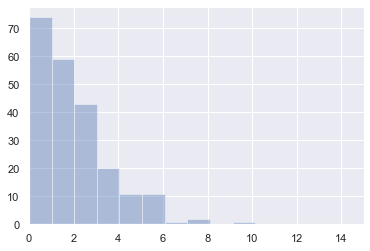

In [41]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Then visualize the Mahalanobis distance itself:

/home/ehsan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Mahalanobis dist')

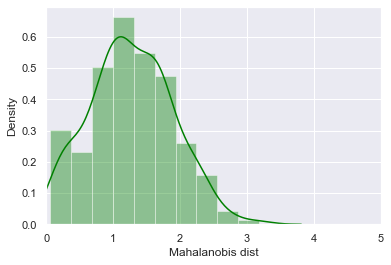

In [51]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

From the above distributions, the calculated threshold value of 3.8 for flagging an anomaly seems reasonable (defined as 3 standard deviations from the center of the distribution)

We can then save the Mahalanobis distance, as well as the threshold value and “anomaly flag” variable for both train and test data in a dataframe:

In [52]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index

anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.032676,3.812045,False
2004-02-14 00:02:39,1.148163,3.812045,False
2004-02-14 00:12:39,1.509998,3.812045,False
2004-02-14 00:22:39,1.849725,3.812045,False
2004-02-14 00:32:39,0.701075,3.812045,False


Based on the calculated statistics, any distance above the threshold value will be flagged as an anomaly.

We can now merge the data in a single dataframe and save it as a .csv file:

In [53]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

Verifying PCA model on test data:

We can now plot the calculated anomaly metric (Mob dist), and check when it crosses the anomaly threshold (note the logarithmic y-axis).

<AxesSubplot:>

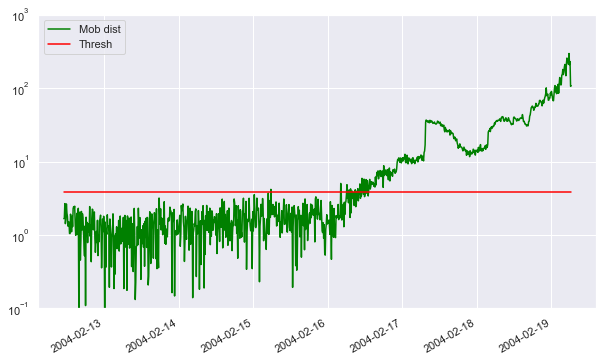

In [54]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])

From the above figure, we see that the model is able to detect the anomaly approximately 3 days ahead of the actual bearing failure.

## Other approach: Autoencoder model for anomaly detection

The basic idea here is to use an autoencoder neural network to “compress” the sensor readings to a low dimensional representation, which captures the correlations and interactions between the various variables. (Essentially the same principle as the PCA model, but here we also allow for non-linearities among the input variables).

For a more detailed introduction to Autoencoders you can have a look at my previous article, which covers the topic in more detail.

## Defining the Autoencoder network:

We use a 3 layer neural network: First layer has 10 nodes, middle layer has 2 nodes, and third layer has 10 nodes. We use the mean square error as loss function, and train the model using the “Adam” optimizer.

In [64]:
seed(10)
tf.random.set_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

## Fitting the model:

To keep track of the accuracy during training, we use 5% of the training data for validation after each epoch (validation_split = 0.05)

In [65]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Epoch 1/100
21/21 [==============================] - 0s 9ms/step - loss: 0.1606 - val_loss: 0.0879
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1116 - val_loss: 0.0590
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0365
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0248
Epoch 5/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0289 - val_loss: 0.0212
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0221
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0186 - val_loss: 0.0233
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0179 - val_loss: 0.0222
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0171 - val_loss: 0.0218
Epoch 10/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0165 - val_loss: 0.0208
Epoch 11/

21/21 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0131
Epoch 84/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0133
Epoch 85/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0097 - val_loss: 0.0134
Epoch 86/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0126
Epoch 87/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0130
Epoch 88/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0132
Epoch 89/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0128
Epoch 90/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0126
Epoch 91/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0096 - val_loss: 0.0128
Epoch 92/100
21/21 [==============================] - 0s 1ms/step - loss: 0.0096 - val_loss: 0.0136
Epoch 93/100


## Visualize training/validation loss:

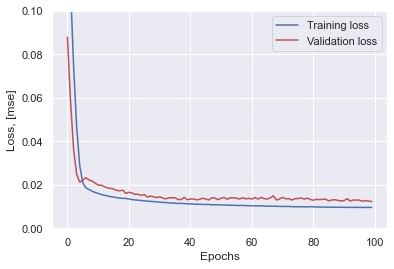

In [66]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

## Distribution of loss function in the training set:

By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level”, and that any flagged anomalies should be statistically significant above the noise background.

/home/ehsan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.5)

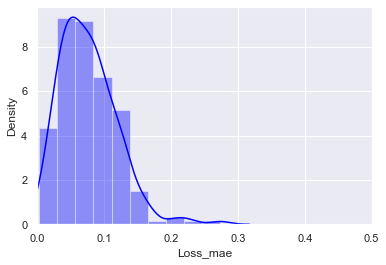

In [68]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let us try a threshold of 0.3 for flagging an anomaly. We can then calculate the loss in the test set, to check when the output crosses the anomaly threshold.

In [69]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.135230,0.3,False
2004-02-14 00:02:39,0.103883,0.3,False
2004-02-14 00:12:39,0.031544,0.3,False
2004-02-14 00:22:39,0.072124,0.3,False
2004-02-14 00:32:39,0.120766,0.3,False


We then calculate the same metrics also for the training set, and merge all data in a single dataframe:

In [71]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

scored = pd.concat([scored_train, scored])

## Results from Autoencoder model:

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure:

<AxesSubplot:>

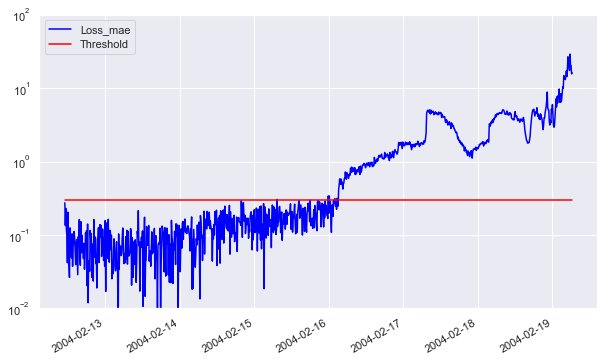

In [72]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])

# Summary:

Both modeling approaches give similar results, where they are able to flag the upcoming bearing malfunction well in advance of the actual failure. The main difference is essentially how to define a suitable threshold value for flagging anomalies, to avoid to many false positives during normal operating conditions.

I hope this tutorial gave you inspiration to try out these anomaly detection models yourselves. Once you have succesfully set up the models, it is time to start experimenting with model parameters etc. and test the same approach on new datasets. If you come across some interesting use cases, please let me know in the comments below.